In [2]:
import tensorflow as tf
import numpy as np
from utils import *
from gtex_gain import *
import matplotlib
import matplotlib.gridspec as gridspec
from collections import Counter
import itertools
from utils import ENSEMBL_to_gene_symbols
from scipy import stats

tfk = tf.keras
tfkl = tf.keras.layers

MODELS_DIR = 'checkpoints/models/'

In [3]:
def limit_gpu(gpu_idx=0, mem=2 * 1024):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
        try:
            # Use a single gpu
            tf.config.experimental.set_visible_devices(gpus[gpu_idx], 'GPU')

            # Limit memory
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem)])  # 2 GB
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)

def get_test_extended(x_test, cat_covs_test, num_covs_test, tissues_test, n = 171*2, nb_tissues=49, m_low=0.5, m_high=0.5):
    # Create extended test dataset (so that all tissues have same number of test samples)
    nb_test, nb_genes = x_test.shape
    x_test_extended = np.empty((nb_tissues * n, nb_genes), dtype=np.float32)
    cat_covs_test_extended = np.empty((nb_tissues * n, cat_covs_test.shape[-1]), dtype=np.int32)
    num_covs_test_extended = np.empty((nb_tissues * n, num_covs_test.shape[-1]), dtype=np.float32)

    for t in range(nb_tissues):
        idxs_tissue = np.argwhere(tissues_test == t).ravel()
        idxs_extended = np.resize(idxs_tissue, n)
        x_test_extended[t*n: (t+1)*n] = x_test[idxs_extended]
        cat_covs_test_extended[t*n: (t+1)*n] = cat_covs_test[idxs_extended]
        num_covs_test_extended[t*n: (t+1)*n] = num_covs_test[idxs_extended]

    # Create mask
    mask, _, _ = get_mask_hint_b(x_test_extended.shape[0], nb_genes, m_low=m_low, m_high=m_high)
    
    return x_test_extended, cat_covs_test_extended, num_covs_test_extended, mask

def compute_r2_score(x_test_extended, x_gen_extended, mask, nb_tissues=49):
    # Compute R^2
    x_test_extended_r = x_test_extended.reshape((nb_tissues, -1, nb_genes))
    assert x_test_extended_r[0, 2, 0] == x_test_extended[2, 0]

    x_gen_extended_r = x_gen_extended.reshape((nb_tissues, -1, nb_genes))  # Shape=(nb_tissues, nb_samples_tissue, nb_genes)
    mask_r = np.copy(mask.reshape((nb_tissues, -1, nb_genes)))
    mask_r[mask_r == 1] = np.nan

    gene_means = np.mean(x_test_extended_r, axis=1)  # Shape=(nb_tissues, nb_genes)

    ss_res = np.nansum((1-mask_r)*(x_test_extended_r - x_gen_extended_r) ** 2, axis=1)
    ss_tot = np.nansum((1-mask_r)*(x_test_extended_r - gene_means[:, None, :]) ** 2, axis=1)

    r_sq = 1 - ss_res/(ss_tot)
    return r_sq

def compute_mse_score(x_test_extended, x_gen_extended, mask, nb_tissues=49):
    # nb_tissues, n, nb_genes = x_test_extended.shape
    
    x_test_extended_r = x_test_extended.reshape((nb_tissues, -1, nb_genes))
    assert x_test_extended_r[0, 2, 0] == x_test_extended[2, 0]

    x_gen_extended_r = x_gen_extended.reshape((nb_tissues, -1, nb_genes))  # Shape=(nb_tissues, nb_samples_tissue, nb_genes)
    mask_r = np.copy(mask.reshape((nb_tissues, -1, nb_genes)))
    mask_r[mask_r == 1] = np.nan
    err = (1-mask_r)*(x_gen_extended_r - x_test_extended_r)**2

    return np.nanmean(err, axis=1)

def box_plot_scores(r_sq, nb_train, tissues_dict_inv):
    colors = plt.cm.rainbow(nb_train.flatten())
    sns.boxplot(x=np.array([[t]*r_sq.shape[1] for t in tissues_dict_inv]).flatten(), y=r_sq.flatten(),
                sym='')
    ax = plt.gca()

    cmap = plt.cm.summer # Greens #Blues # viridis
    colors = cmap(nb_train.flatten())
    for i, a in enumerate(ax.artists):
        # Change the appearance of that box
        a.set_facecolor(colors[i])
        # a.set_edgecolor('black')
        # a.set_linewidth(3)

    norm = plt.Normalize(nb_train.min(), nb_train.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
    plt.xticks(rotation=90)

    # ax.figure.colorbar(colors)
    ax.set_ylim([0, 1])
    plt.title('$R^2$ imputation scores per tissue')
    return plt.gca()

In [4]:
# GPU
limit_gpu(0)

In [5]:
# Load dataset
x, symbols, sampl_ids, tissues = load_gtex()
x = standardize(x)
x = np.float32(x)

# Load metadata
df_metadata = gtex_metadata()
print(df_metadata.head())

# Process categorical metadata
cat_cols = ['SEX', 'COHORT']  # 'SEX', 'COHORT'
df_metadata[cat_cols] = df_metadata[cat_cols].astype('category')
# cat_map = df_metadata[cat_cols].cat.categories
# print('cat map', cat_map)
cat_dicts = [df_metadata[cat_col].cat.categories.values for cat_col in cat_cols]
df_metadata[cat_cols] = df_metadata[cat_cols].apply(lambda x: x.cat.codes)
cat_covs = df_metadata.loc[sampl_ids, cat_cols].values
tissues_dict_inv = np.array(list(sorted(set(tissues))))
tissues_dict = {t: i for i, t in enumerate(tissues_dict_inv)}
tissues = np.vectorize(lambda t: tissues_dict[t])(tissues)
cat_dicts.append(tissues_dict_inv)
cat_covs = np.concatenate((cat_covs, tissues[:, None]), axis=-1)

cat_covs = np.int32(cat_covs)
print('Cat covs: ', cat_covs.shape)

# Process numerical metadata
num_cols = ['AGE']
num_covs = df_metadata.loc[sampl_ids, num_cols].values
num_covs = standardize(num_covs)
num_covs = np.float32(num_covs)
# num_covs = np.zeros_like(cat_covs).astype(np.float32)

# Train/test split
x_train, x_test, sampl_ids_train, sampl_ids_test = split_train_test_v2(x, sampl_ids)
num_covs_train, num_covs_test, _, _ = split_train_test_v2(num_covs, sampl_ids)
cat_covs_train, cat_covs_test, _, _ = split_train_test_v2(cat_covs, sampl_ids)

# Mask test data
nb_samples, nb_genes = x_test.shape
mask, _, _ = get_mask_hint_b(nb_samples, nb_genes, m_low=0.5, m_high=0.5)
x_test_ = x_test * mask

tissues_train = cat_covs_train[:, 2]
tissues_test = cat_covs_test[:, 2]
nb_tissues=49

                A1BG     A2LD1       A2M     A2ML1    A4GALT      AAAS  \
GTEX-NL4W   0.415623 -0.496085 -0.811018 -0.496085 -0.031079  1.374065   
GTEX-13O3O  0.053586 -0.681229 -0.444875 -0.126741 -1.118748  0.109482   
GTEX-12ZZW -0.292021  1.102440  0.717650  0.591696  0.512776  1.744448   
GTEX-XK95   1.282401 -2.066852  1.353622  1.442962  1.883649  0.031758   
GTEX-QDVJ  -0.051706 -0.181889  0.650353 -0.490597  1.038647 -0.288197   

                AACS     AAED1     AAGAB      AAK1  ...      ZW10    ZWILCH  \
GTEX-NL4W   0.720732 -2.040281  1.274520 -0.082959  ...  0.661543  0.741026   
GTEX-13O3O -0.209333 -1.056810 -0.302340  0.725124  ... -0.904346  1.541986   
GTEX-12ZZW -1.071858  0.292021 -1.606755 -0.739737  ... -0.204660 -1.671644   
GTEX-XK95  -0.117946 -0.919804 -0.853391 -0.663975  ... -1.783434 -0.668639   
GTEX-QDVJ   0.363147  1.038647  0.757996  0.626590  ...  1.038647  0.610943   

               ZWINT      ZXDA      ZXDB      ZXDC    ZYG11B       ZYX  \
GTEX-N

In [6]:
# Evaluate data
gen = tfk.models.load_model(MODELS_DIR + 'gen_gain_l1.0.h5')

print('Generating synthetic data...')
x_gen = predict(x=x_test_,
                cc=cat_covs_test,
                nc=num_covs_test,
                mask=mask,
                gen=gen)

"""
gamma_dx_dz = gamma_coef(x_test, x_gen)
gamma_dx_dz_upper_bound = gamma_coef(x_test, x_train[:x_test.shape[0], :])
print('Gamma(Dx, Dz): {:.3f}/{:.3f}'.format(gamma_dx_dz, gamma_dx_dz_upper_bound))
"""

imp_mse = np.sum((1-mask)*(x_gen - x_test)**2)/np.sum(1-mask)
imp_mse

Generating synthetic data...


0.31727153

# Quantification of GAIN imputation performance

In [204]:
m_rate = 0.5
x_test_extended, cat_covs_test_extended, num_covs_test_extended, mask_extended = get_test_extended(x_test,
                                                                                          cat_covs_test,
                                                                                          num_covs_test,
                                                                                          tissues_test,
                                                                                          n = 171*2,
                                                                                          m_low=m_rate, m_high=m_rate)

# Get predictions
x_test_extended_ = x_test_extended * mask_extended

In [205]:
# Evaluate data
print('Generating synthetic data...')
x_gen_extended = predict(x=x_test_extended_,
                         cc=cat_covs_test_extended,
                         nc=num_covs_test_extended,
                         mask=mask_extended,
                         gen=gen)
x_gen_extended_ = x_gen_extended * (1 - mask_extended) + x_test_extended_

Generating synthetic data...


In [206]:
# Compute R^2
r_sq = compute_r2_score(x_test_extended, x_gen_extended_, mask_extended)
r_sq

array([[0.5971208 , 0.7233582 , 0.6362704 , ..., 0.80134267, 0.8398829 ,
        0.82344115],
       [0.599748  , 0.7455858 , 0.7176932 , ..., 0.85332114, 0.82378143,
        0.85704195],
       [0.58379006, 0.5799052 , 0.46078718, ..., 0.6421074 , 0.6721755 ,
        0.59903437],
       ...,
       [0.16574585, 0.5966375 , 0.66263604, ..., 0.87746227, 0.8489743 ,
        0.7449435 ],
       [0.6387204 , 0.5973983 , 0.81520593, ..., 0.7377074 , 0.81009483,
        0.7831266 ],
       [0.57573396, 0.67499393, 0.65781975, ..., 0.85909635, 0.8059906 ,
        0.84417593]], dtype=float32)

In [207]:
# Save scores
df = pd.DataFrame(data=r_sq, index=tissues_dict_inv, columns=symbols)
df.to_csv('R2_tissue_genes.csv')
df.head()

,A1BG,A2LD1,A2M,A2ML1,A4GALT,AAAS,AACS,AAED1,AAGAB,AAK1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Adipose_Subcutaneous,0.597121,0.723358,0.636270,0.449175,0.824902,0.714844,0.779734,0.704167,0.772811,0.648857,...,0.703765,0.697912,0.684051,0.638007,0.644460,0.599445,0.709789,0.801343,0.839883,0.823441
Adipose_Visceral_Omentum,0.599748,0.745586,0.717693,0.369564,0.655509,0.804529,0.814875,0.865418,0.874582,0.560959,...,0.735667,0.767064,0.818011,0.697657,0.676645,0.666649,0.710788,0.853321,0.823781,0.857042
Adrenal_Gland,0.583790,0.579905,0.460787,0.326234,0.399458,0.678247,0.471721,0.586143,0.660325,0.588077,...,0.814203,0.668079,0.823612,0.616608,0.626058,0.549016,0.772327,0.642107,0.672176,0.599034
Artery_Aorta,0.292311,0.504298,0.663141,0.446680,0.605295,0.813041,0.397466,0.775161,0.873897,0.576391,...,0.798419,0.729062,0.787152,0.617864,0.734985,0.722898,0.767448,0.820607,0.807180,0.753468
Artery_Coronary,0.633345,0.522217,0.668925,0.565774,0.406925,0.815732,0.680109,0.792678,0.848584,0.680877,...,0.733668,0.701341,0.846060,0.414263,0.775575,0.623051,0.767098,0.906637,0.795112,0.662233


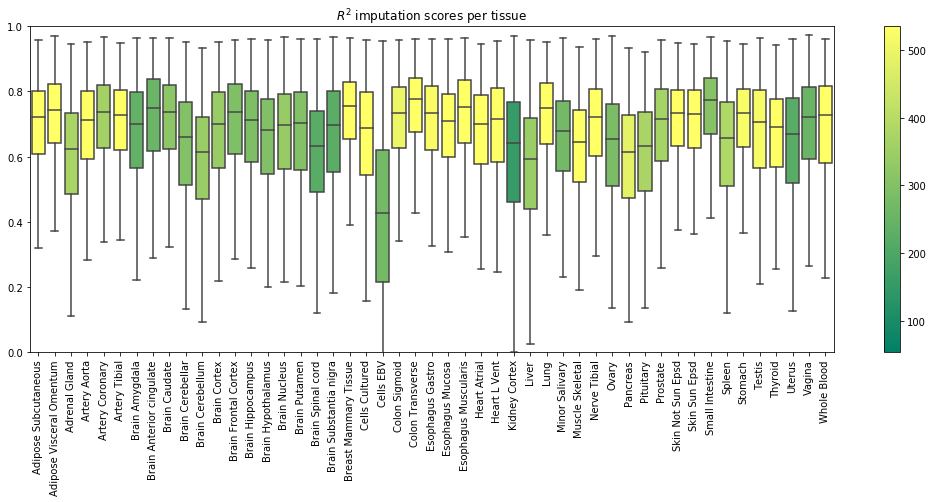

In [253]:
counter_train = Counter(tissues_train)
nb_train = np.array([counter_train[t] for t in np.arange(nb_tissues)])
fig=plt.figure(figsize=(18, 6))
plt.tight_layout()
box_plot_scores(r_sq, nb_train, [t.replace('_', ' ') for t in tissues_dict_inv])
plt.savefig('r2_scores_horizontal.pdf', bbox_inches = 'tight', pad_inches = 0);

In [209]:
np.mean(r_sq)

0.6596143

In [210]:
mse_gain = compute_mse_score(x_test_extended, x_gen_extended_, mask_extended)
mse_gain

array([[0.45998338, 0.26510254, 0.32398483, ..., 0.19833747, 0.15210977,
        0.19484788],
       [0.40473986, 0.26962355, 0.34287918, ..., 0.1443254 , 0.17388177,
        0.15158696],
       [0.39005196, 0.48903787, 0.545534  , ..., 0.37727562, 0.24299975,
        0.32497957],
       ...,
       [0.50806224, 0.3102942 , 0.22308369, ..., 0.13961357, 0.13930015,
        0.23351635],
       [0.3600384 , 0.41248283, 0.1722582 , ..., 0.20299813, 0.16463949,
        0.2290802 ],
       [0.47944415, 0.36623883, 0.3427331 , ..., 0.17363639, 0.18314321,
        0.1621403 ]], dtype=float32)

In [211]:
np.mean(mse_gain)

0.32354584

In [234]:
def box_plot_scores_vertical(r_sq, nb_train, tissues_dict_inv):
    colors = plt.cm.rainbow(nb_train.flatten())
    sns.boxplot(y=np.array([[t]*r_sq.shape[1] for t in tissues_dict_inv]).flatten(), x=r_sq.flatten(),
                sym='')
    ax = plt.gca()

    cmap = plt.cm.summer # Greens #Blues # viridis
    colors = cmap(nb_train.flatten())
    for i, a in enumerate(ax.artists):
        # Change the appearance of that box
        a.set_facecolor(colors[i])
        # a.set_edgecolor('black')
        # a.set_linewidth(3)

    norm = plt.Normalize(nb_train.min(), nb_train.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    
    plt.colorbar(sm, fraction=0.03, pad=0.04)
    # plt.xticks(rotation=90)

    # ax.figure.colorbar(colors)
    ax.set_xlim([0, 1])
    plt.title('$R^2$ imputation scores per tissue')
    return plt.gca()

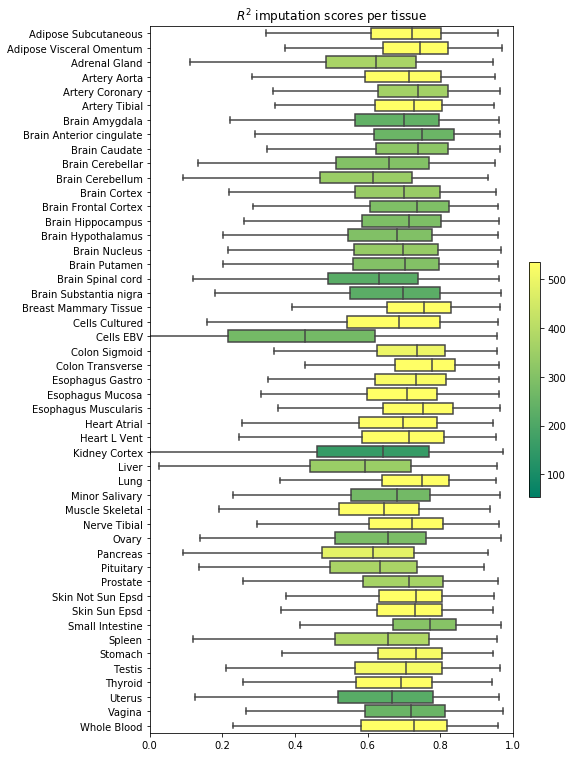

In [252]:
counter_train = Counter(tissues_train)
nb_train = np.array([counter_train[t] for t in np.arange(nb_tissues)])
fig=plt.figure(figsize=(7, 13))
plt.tight_layout()
box_plot_scores_vertical(r_sq, nb_train, [t.replace('_', ' ') for t in tissues_dict_inv])
plt.savefig('r2_scores_vertical.pdf', bbox_inches = 'tight', pad_inches = 0);

# Baselines

## Median/mean imputation

In [51]:
nb_train, nb_genes = x_train.shape
tissues_train = cat_covs_train[:, 2]
gene_medians = []
gene_means = []

for t in range(nb_tissues):
    idxs_tissue = np.argwhere(tissues_train == t).ravel()
    medians = np.median(x_train[idxs_tissue], axis=0)
    means = np.mean(x_train[idxs_tissue], axis=0)
    gene_medians.append(medians)
    gene_means.append(means)
    
gene_medians = np.array(gene_medians)
gene_means = np.array(gene_means)

In [52]:
gene_means

array([[ 0.05005522, -0.04398116,  0.04309649, ...,  0.01345565,
        -0.03926537,  0.03875999],
       [ 0.03048508, -0.01229123,  0.00777435, ..., -0.00919176,
         0.00224531,  0.02450181],
       [-0.00575218,  0.01932614,  0.01427537, ...,  0.01770428,
         0.01287358,  0.00890747],
       ...,
       [-0.00419896, -0.01844651, -0.00532871, ...,  0.00082261,
        -0.00723013,  0.02288798],
       [ 0.03693314,  0.04836682, -0.00848866, ..., -0.01553903,
        -0.0321542 ,  0.01494453],
       [ 0.01122271,  0.00131311,  0.04269641, ...,  0.01239214,
        -0.02484128,  0.00883528]], dtype=float32)

In [53]:
gene_medians

array([[ 6.5663859e-02, -6.1280765e-02,  4.8137989e-02, ...,
        -1.7499039e-02, -5.6898806e-02,  4.3758966e-02],
       [ 5.4170131e-03,  3.2507475e-02,  1.0834181e-02, ...,
        -3.7927724e-02, -5.4170131e-03,  3.7927724e-02],
       [-5.4427408e-02,  3.2646444e-02, -1.0880482e-02, ...,
        -9.4954120e-19,  1.0880482e-02, -1.0880482e-02],
       ...,
       [-4.8982494e-02, -4.8982494e-02,  0.0000000e+00, ...,
         1.9589350e-02, -8.8245228e-02,  2.9393142e-02],
       [ 9.8771378e-02,  3.5871979e-02, -1.7933192e-02, ...,
        -2.6898392e-02, -6.2795565e-02,  2.6898392e-02],
       [ 1.8972702e-02, -1.8972702e-02,  5.3144716e-02, ...,
         1.5177844e-02, -1.8972702e-02,  3.0359078e-02]], dtype=float32)

In [54]:
x_test_extended_r = x_test_extended.reshape((nb_tissues, -1, nb_genes))  # Ground truth
x_test_extended_r_ = x_test_extended_.reshape((nb_tissues, -1, nb_genes))  # Ground truth with missing values
mask_r = np.copy(mask_extended.reshape((nb_tissues, -1, nb_genes)))
assert (x_test_extended_r_ == (x_test_extended_r * mask_r)).all()

x_test_median_imp = x_test_extended_r * mask_r + gene_medians[:, None, :] * (1 - mask_r) 
x_test_mean_imp = x_test_extended_r * mask_r + gene_means[:, None, :] * (1 - mask_r) 

In [55]:
r_sq_medians = compute_r2_score(x_test_extended, x_test_median_imp.reshape((-1, nb_genes)), mask_extended)
r_sq_means = compute_r2_score(x_test_extended, x_test_mean_imp.reshape((-1, nb_genes)), mask_extended)
r_sq_medians

array([[-0.01901591, -0.07005024, -0.07878125, ..., -0.01329815,
        -0.02263153, -0.05871642],
       [-0.02260244, -0.00104725, -0.00171661, ..., -0.0069077 ,
        -0.00030434, -0.00757349],
       [-0.00867581, -0.00348973, -0.00344694, ..., -0.0098629 ,
         0.00050682, -0.00031567],
       ...,
       [-0.02411008,  0.00413305, -0.00318694, ...,  0.00245249,
        -0.01796401, -0.01268673],
       [-0.08362472, -0.06465936, -0.00053716, ..., -0.00242722,
        -0.02407897, -0.00552499],
       [-0.00457919,  0.00024068, -0.03988278, ...,  0.00433695,
        -0.02480876, -0.00067103]], dtype=float32)

In [56]:
np.mean(r_sq_medians)

-0.024690242

In [57]:
np.mean(r_sq_means)

-0.0233357

In [58]:
np.mean(r_sq_means, axis=-1)

array([-0.01542974, -0.0063635 , -0.0138987 , -0.01468555, -0.03162378,
       -0.01055263, -0.03293853, -0.02797207, -0.01623744, -0.04342028,
       -0.02115359, -0.03277623, -0.04267547, -0.04851209, -0.03756683,
       -0.02173404, -0.02152009, -0.04411898, -0.03846614, -0.01104596,
       -0.01889615, -0.0455822 , -0.01125429, -0.02259999, -0.01670933,
       -0.00947767, -0.0077499 , -0.01466935, -0.00926561, -0.0552163 ,
       -0.01689647, -0.0075293 , -0.06179129, -0.00688953, -0.00856687,
       -0.03300994, -0.01691046, -0.0327621 , -0.02647884, -0.01427506,
       -0.00709335, -0.03661293, -0.03021097, -0.01496204, -0.01391522,
       -0.00668745, -0.03035525, -0.02888917, -0.00550023], dtype=float32)

In [59]:
mse_median = compute_mse_score(x_test_extended, x_test_median_imp.reshape((-1, nb_genes)), mask_extended)

In [60]:
np.sqrt(np.mean(mse_median))

0.99395794

In [61]:
r_sqs_mean = []
r_sqs_median = []
rmses_mean = []
rmses_median = []

for n in range(10):
    print(n+1)
    x_test_extended, cat_covs_test_extended, num_covs_test_extended, mask_extended = get_test_extended(x_test,
                                                                                              cat_covs_test,
                                                                                              num_covs_test,
                                                                                              tissues_test,
                                                                                              n = 171*2,
                                                                                              m_high=m_rate,
                                                                                              m_low=m_rate)
    x_test_extended_ = x_test_extended * mask_extended

    x_test_extended_r = x_test_extended.reshape((nb_tissues, -1, nb_genes))  # Ground truth
    x_test_extended_r_ = x_test_extended_.reshape((nb_tissues, -1, nb_genes))  # Ground truth with missing values
    mask_r = np.copy(mask_extended.reshape((nb_tissues, -1, nb_genes)))
    assert (x_test_extended_r_ == (x_test_extended_r * mask_r)).all()

    x_test_median_imp = x_test_extended_r * mask_r + gene_medians[:, None, :] * (1 - mask_r) 
    x_test_mean_imp = x_test_extended_r * mask_r + gene_means[:, None, :] * (1 - mask_r) 
    
    r_sq_medians = compute_r2_score(x_test_extended, x_test_median_imp.reshape((-1, nb_genes)), mask_extended)
    r_sq_means = compute_r2_score(x_test_extended, x_test_mean_imp.reshape((-1, nb_genes)), mask_extended)
    mse_medians = compute_mse_score(x_test_extended, x_test_median_imp.reshape((-1, nb_genes)), mask_extended)
    mse_means = compute_mse_score(x_test_extended, x_test_mean_imp.reshape((-1, nb_genes)), mask_extended)

    print('R^2 Mean: ', np.mean(r_sq_means))
    print('R^2 Median: ', np.mean(r_sq_medians))
    rmses_mean.append(mse_means)
    rmses_median.append(mse_medians)
    r_sqs_mean.append(r_sq_means)
    r_sqs_median.append(r_sq_medians)

1
R^2 Mean:  -0.023358041
R^2 Median:  -0.024709953
2
R^2 Mean:  -0.023355605
R^2 Median:  -0.024708562
3
R^2 Mean:  -0.023392929
R^2 Median:  -0.024748113
4
R^2 Mean:  -0.023409434
R^2 Median:  -0.024760138
5
R^2 Mean:  -0.023404904
R^2 Median:  -0.024761118
6
R^2 Mean:  -0.023357203
R^2 Median:  -0.024705764
7
R^2 Mean:  -0.023347478
R^2 Median:  -0.024702456
8
R^2 Mean:  -0.023415828
R^2 Median:  -0.024766913
9
R^2 Mean:  -0.02338466
R^2 Median:  -0.024732461
10
R^2 Mean:  -0.023375051
R^2 Median:  -0.02473271


In [62]:
np.std(r_sqs_mean)

0.044350803

In [86]:
r_sqs_mean_ = np.array(r_sqs_mean)
np.mean(r_sqs_mean_)

-0.023380121

In [92]:
np.mean(np.std(r_sqs_mean_, axis=0))

0.011928863

In [95]:
rmses_mean_ = np.sqrt(np.array(rmses_median))
np.mean(rmses_mean_)

0.9901507

In [96]:
np.mean(np.std(rmses_mean_, axis=0))

0.0324742

## Whole blood surrogate

In [64]:
blood_idx = tissues_dict['Whole_Blood']
blood_idxs = np.argwhere(tissues_test == blood_idx).ravel()
surrogate_expr = x_test[blood_idxs, :]
patients_with_blood_tissue = sampl_ids_test[blood_idxs]


In [65]:
blood_idxs

array([  35,   64,   93,  114,  134,  140,  164,  190,  254,  273,  286,
        321,  343,  359,  400,  406,  462,  471,  496,  506,  515,  555,
        599,  608,  641,  645,  673,  697,  710,  726,  744,  772,  779,
        791,  818,  839,  854,  888,  902,  909,  950,  977, 1006, 1016,
       1018, 1024, 1077, 1092, 1122, 1153, 1165, 1191, 1217, 1234, 1245,
       1280, 1295, 1313, 1330, 1366, 1369, 1440, 1465, 1480, 1509, 1535,
       1568, 1622, 1636, 1649, 1670, 1696, 1731, 1738, 1764, 1767, 1773,
       1812, 1815, 1848, 1873, 1918, 1943, 1957, 1975, 1984, 2067, 2075,
       2091, 2114, 2138, 2161, 2181, 2205, 2224, 2255, 2262, 2296, 2327,
       2353, 2357, 2390, 2425, 2437, 2455, 2479, 2510, 2519, 2538, 2544,
       2563, 2584, 2601, 2618, 2638, 2655, 2679, 2684, 2708, 2741, 2759,
       2774, 2816, 2839, 2854, 2876, 2880, 2902, 2928, 2958, 3026, 3027,
       3049, 3077, 3082, 3118, 3140, 3167, 3174, 3191, 3210, 3236, 3268,
       3276, 3301, 3325, 3343, 3352, 3378, 3384, 33

In [66]:
x_test_blood_extended = [[] for _ in range(nb_tissues)]
x_test_blood_surrogate = [[] for _ in range(nb_tissues)]

for i, idx in enumerate(blood_idxs):
    patient_id = sampl_ids_test[idx]
    blood_expr = x_test[idx, :]  # surrogate_expr[i, :]
    samples_patient = [j for j, s in enumerate(sampl_ids_test) if s == patient_id]
    
    for s in samples_patient:
        t = tissues_test[s]
        expr = x_test[s, :]
        x_test_blood_extended[t].append(expr)
        x_test_blood_surrogate[t].append(blood_expr)    

In [67]:
n = 171*2
x_surrogate_extended = np.empty((nb_tissues * n, nb_genes), dtype=np.float32)
x_test_tissue_extended = np.empty((nb_tissues * n, nb_genes), dtype=np.float32)
for t in range(nb_tissues):
    x_t = np.array(x_test_blood_extended[t])  # Tissue expression that we want to impute
    x_s = np.array(x_test_blood_surrogate[t])  # Blood expression
    if np.all(x_t == x_s):  # Imputing whole blood
        assert t == blood_idx
    x_surrogate_extended[t*n: (t+1)*n, :] = np.resize(x_s, [n, nb_genes])
    x_test_tissue_extended[t*n: (t+1)*n, :] = np.resize(x_t, [n, nb_genes])

In [68]:
assert np.all(x_test_tissue_extended[n] == x_test_blood_extended[1][0])
assert np.all(x_test_tissue_extended[10*n+2] == x_test_blood_extended[10][2])

In [69]:
np.resize([[0, 7], [1, 1], [2, 2]], [6, 2])

array([[0, 7],
       [1, 1],
       [2, 2],
       [0, 7],
       [1, 1],
       [2, 2]])

In [70]:
x_test_tissue_extended_r = x_test_tissue_extended.reshape((nb_tissues, -1, nb_genes))  # Ground truth
x_surrogate_extended_r = x_surrogate_extended.reshape((nb_tissues, -1, nb_genes))  # Blood surrogate

i = 2
j = 3
assert np.all(x_test_tissue_extended_r[i, j, :] == x_test_tissue_extended[i*n + j])

In [71]:
n = 10
m_rate = 0.5

r_sqs_surrogate = []
rmses_surrogate = []
for n in range(10):
    print(n+1)
    
    # Generate mask
    mask_extended, _, _ = get_mask_hint_b(x_test_tissue_extended.shape[0], nb_genes, m_low=m_rate, m_high=m_rate)
    mask_extended_r = mask_extended.reshape((nb_tissues, -1, nb_genes))
    
    # Perform blood surrogate imputation and compute scores
    x_test_surrogate_imp = x_test_tissue_extended_r * mask_extended_r + x_surrogate_extended_r * (1 - mask_extended_r)
    r_sq_surrogate = compute_r2_score(x_test_tissue_extended, x_test_surrogate_imp.reshape((-1, nb_genes)), mask_extended)
    mse_surrogate = compute_mse_score(x_test_tissue_extended, x_test_surrogate_imp.reshape((-1, nb_genes)), mask_extended)
    
    # Append scores
    r_sqs_surrogate.append(r_sq_surrogate)
    rmses_surrogate.append(np.sqrt(mse_surrogate))

1
2
3
4
5
6
7
8
9
10


In [98]:
rmses_surrogate_ = np.array(rmses_surrogate)
means = np.nanmean(rmses_surrogate_)
stds = np.nanmean(np.std(rmses_surrogate_, axis=0))

In [101]:
r_sqs_surrogate_ = np.array(r_sqs_surrogate)
np.mean(r_sqs_surrogate_)

-0.9245813

In [102]:
np.nanmean(np.std(r_sqs_surrogate_, axis=0))

0.13666794

In [73]:
np.array(r_sqs_surrogate).shape

(10, 49, 12557)

In [74]:
np.std(np.mean(r_sqs_surrogate, axis=(1, 2)))

0.0001746905

In [75]:
np.std(rmses_surrogate)

0.26831305

In [76]:
mask_r = np.copy(mask_extended.reshape((nb_tissues, -1, nb_genes)))

x_test_surrogate_imp = x_test_tissue_extended_r * mask_r + x_surrogate_extended_r * (1 - mask_r) 

In [77]:
r_sq_surrogate = compute_r2_score(x_test_tissue_extended, x_test_surrogate_imp.reshape((-1, nb_genes)), mask_extended)
r_sq_surrogate

array([[-0.7786313 , -1.2187138 , -1.5690517 , ..., -2.2547338 ,
        -0.5388429 , -1.1401689 ],
       [-0.9559027 , -1.3933585 , -0.726418  , ..., -0.9196038 ,
        -0.60019064, -1.1299491 ],
       [-0.7016294 , -1.6627765 , -0.91662145, ..., -1.0270908 ,
        -1.1312623 , -1.537173  ],
       ...,
       [-1.5149479 , -1.575624  , -1.6237504 , ..., -0.03951848,
        -0.1623286 , -0.95640516],
       [-1.2295887 , -2.0555816 , -1.1710124 , ..., -1.2881944 ,
         0.04236978, -1.5056312 ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]], dtype=float32)

In [ ]:
mse_surrogate = compute_mse_score(x_test_tissue_extended, x_test_surrogate_imp.reshape((-1, nb_genes)), mask_extended)

In [ ]:
np.mean(r_sq_surrogate)

In [ ]:
np.mean(mse_surrogate)

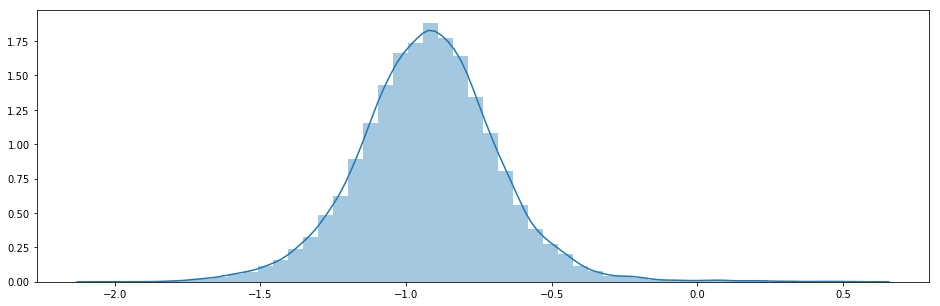

In [253]:
plt.figure(figsize=(16, 5))
sns.distplot(np.mean(r_sq_surrogate, axis=0));

In [254]:
df = pd.DataFrame(data=r_sq_surrogate, index=tissues_dict_inv, columns=symbols)
df.to_csv('R2_tissue_genes_blood_surrogate.csv')
df.head()

,A1BG,A2LD1,A2M,A2ML1,A4GALT,AAAS,AACS,AAED1,AAGAB,AAK1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Adipose_Subcutaneous,-0.465550,-1.173762,-1.032810,-0.730213,-0.270471,-0.655211,-1.634569,-1.067080,-1.094740,-1.244874,...,-1.417265,-0.585820,-0.732598,-0.639962,-1.723454,-0.414117,-0.696137,-1.917946,-0.694488,-0.847165
Adipose_Visceral_Omentum,-0.827604,-1.375535,-0.680563,-0.704773,-0.633021,-0.608253,-1.584709,-1.001357,-0.360470,-1.636813,...,-1.080009,-0.829131,-0.599599,-0.273452,-1.123344,0.050994,-1.110006,-0.626136,-0.283517,-0.766029
Adrenal_Gland,-0.804469,-1.518419,-0.602952,-1.600914,-0.407288,0.076463,-1.482806,-0.851986,-0.583035,-1.088462,...,-0.595917,-1.144425,-1.188788,-1.385033,-1.118926,-1.426160,-0.749303,-1.020880,-1.401049,-1.383555
Artery_Aorta,-0.706330,-2.018515,-1.107732,-0.747537,-0.765589,-0.145269,-1.209920,-1.144468,-0.486276,-0.395245,...,-1.206246,-2.594680,-1.745168,-0.712997,-1.487693,0.150633,-0.600528,-0.674877,-0.767245,-1.463147
Artery_Coronary,-0.498524,-2.540530,-0.956385,-0.896598,-1.909934,-0.278824,-1.258355,-1.461828,-0.465149,-2.084587,...,-1.050406,-1.821801,-1.605723,-1.762418,-3.081410,-0.312061,-0.579146,-1.567639,-0.829543,-2.748992


## GAIN without adversarial loss

In [78]:
gen_mse = tfk.models.load_model(MODELS_DIR + 'gen_gain_mse.h5')

print('Generating synthetic data...')
x_gen = predict(x=x_test_,
                cc=cat_covs_test,
                nc=num_covs_test,
                mask=mask,
                gen=gen_mse)

gamma_dx_dz = gamma_coef(x_test, x_gen)
gamma_dx_dz_upper_bound = gamma_coef(x_test, x_train[:x_test.shape[0], :])
print('Gamma(Dx, Dz): {:.3f}/{:.3f}'.format(gamma_dx_dz, gamma_dx_dz_upper_bound))

imp_mse = np.sum((1-mask)*(x_gen - x_test)**2)/np.sum(1-mask)
imp_mse

Generating synthetic data...
Gamma(Dx, Dz): 0.981/0.979


0.32730514

In [79]:
"""
x_test_extended, cat_covs_test_extended, num_covs_test_extended, mask_extended = get_test_extended(x_test,
                                                                                          cat_covs_test,
                                                                                          num_covs_test,
                                                                                          tissues_test,
                                                                                          n = 171*2)

# Get predictions
x_test_extended_ = x_test_extended * mask_extended
"""


# Evaluate data
print('Generating synthetic data...')
x_gen_extended = predict(x=x_test_extended_,
                         cc=cat_covs_test_extended,
                         nc=num_covs_test_extended,
                         mask=mask_extended,
                         gen=gen_mse)
x_gen_extended_ = x_gen_extended * (1 - mask_extended) + x_test_extended_

Generating synthetic data...


In [80]:
# Compute R^2
r_sq_gain_mse = compute_r2_score(x_test_extended, x_gen_extended_, mask_extended)
r_sq_gain_mse

array([[0.6051409 , 0.7093468 , 0.6999547 , ..., 0.8468932 , 0.91338265,
        0.85256827],
       [0.60795265, 0.7820159 , 0.7247    , ..., 0.8554283 , 0.86653817,
        0.8722453 ],
       [0.48502374, 0.5614444 , 0.52659047, ..., 0.65174806, 0.76336   ,
        0.55013984],
       ...,
       [0.08766377, 0.6190119 , 0.68072116, ..., 0.88254774, 0.83068514,
        0.796637  ],
       [0.59547424, 0.6362891 , 0.7809222 , ..., 0.80753005, 0.8359147 ,
        0.8016744 ],
       [0.58995414, 0.6585314 , 0.6742593 , ..., 0.85559624, 0.84362924,
        0.85372895]], dtype=float32)

In [81]:
np.mean(r_sq_gain_mse)

0.6787739

In [12]:
x_test_extended.shape

(16758, 12557)

In [203]:
nb_tissues=49
counter_train = Counter(tissues_train)
nb_train = np.array([counter_train[t] for t in np.arange(nb_tissues)])
fig=plt.figure(figsize=(18, 6))
box_plot_scores(r_sq_gain_mse, nb_train, tissues_dict_inv);

NameError: name 'r_sq_gain_mse' is not defined

<Figure size 1296x432 with 0 Axes>

In [14]:
mse_gain_mse = compute_mse_score(x_test_extended, x_gen_extended_.reshape((-1, nb_genes)), mask_extended)
mse_gain_mse

array([[0.3545496 , 0.35211533, 0.35976326, ..., 0.19906573, 0.15257594,
        0.15468632],
       [0.45075125, 0.24312732, 0.35246515, ..., 0.12357556, 0.15948376,
        0.17870072],
       [0.3304031 , 0.37197587, 0.44138998, ..., 0.31704688, 0.2606156 ,
        0.28166068],
       ...,
       [0.50290644, 0.26859412, 0.21137893, ..., 0.12276924, 0.12691528,
        0.25487655],
       [0.31001687, 0.30128324, 0.23529553, ..., 0.17883265, 0.16051117,
        0.18712462],
       [0.45321292, 0.37020257, 0.30203366, ..., 0.15107359, 0.17677854,
        0.15517946]], dtype=float32)

In [15]:
np.mean(mse_gain_mse)

0.3032325

In [ ]:
# Compute intervals
m_rate = 0.5

r_sqs = []
r_sqs_mse = []
rmses = []
rmses_mse = []

for n in range(10):
    x_test_extended, cat_covs_test_extended, num_covs_test_extended, mask_extended = get_test_extended(x_test,
                                                                                              cat_covs_test,
                                                                                              num_covs_test,
                                                                                              tissues_test,
                                                                                              n = 171*2,
                                                                                              m_high=m_rate,
                                                                                              m_low=m_rate)

    # Get predictions
    x_test_extended_ = x_test_extended * mask_extended

    # Evaluate data for GAIN
    print('Generating synthetic data...')
    x_gen_extended = predict(x=x_test_extended_,
                             cc=cat_covs_test_extended,
                             nc=num_covs_test_extended,
                             mask=mask_extended,
                             gen=gen)
    x_gen_extended_ = x_gen_extended * (1 - mask_extended) + x_test_extended_
    
    r_sq_gain = compute_r2_score(x_test_extended, x_gen_extended_, mask_extended)
    r_sqs.append(r_sq_gain)
    
    mse_gain = compute_mse_score(x_test_extended, x_gen_extended_.reshape((-1, nb_genes)), mask_extended)
    rmses.append(mse_gain)
    
    print('R^2 GAIN: ', np.mean(r_sq_gain))
    
    # Evaluate data for GAIN_MSE
    print('Generating synthetic data...')
    x_gen_extended = predict(x=x_test_extended_,
                             cc=cat_covs_test_extended,
                             nc=num_covs_test_extended,
                             mask=mask_extended,
                             gen=gen_mse)
    x_gen_extended_ = x_gen_extended * (1 - mask_extended) + x_test_extended_
    
    r_sq_gain_mse = compute_r2_score(x_test_extended, x_gen_extended_, mask_extended)
    r_sqs_mse.append(r_sq_gain_mse)
    
    mse_gain_mse = compute_mse_score(x_test_extended, x_gen_extended_.reshape((-1, nb_genes)), mask_extended)
    rmses_mse.append(mse_gain_mse)
    
    print('R^2 GAIN MSE: ', np.mean(r_sq_gain_mse))


Generating synthetic data...
R^2 GAIN:  0.6597614
Generating synthetic data...
R^2 GAIN MSE:  0.6499387
Generating synthetic data...
R^2 GAIN:  0.65969837
Generating synthetic data...
R^2 GAIN MSE:  0.64998245
Generating synthetic data...
R^2 GAIN:  0.6596394
Generating synthetic data...


In [636]:
np.std(r_sq_gain, axis=-1)

array([0.15357977, 0.15022294, 0.18363889, 0.16610646, 0.15933692,
       0.15212874, 0.18731394, 0.18045992, 0.16438049, 0.19152899,
       0.1887051 , 0.18060642, 0.1715054 , 0.17508729, 0.17912336,
       0.17748149, 0.18985352, 0.1915376 , 0.20139387, 0.14580551,
       0.18862933, 0.26997975, 0.15218192, 0.14163004, 0.15799463,
       0.15550828, 0.1544722 , 0.16969478, 0.17176346, 0.24928944,
       0.19801529, 0.1495864 , 0.17371753, 0.16472468, 0.1632381 ,
       0.1891274 , 0.18559164, 0.18277833, 0.17200562, 0.14497718,
       0.14834878, 0.14896867, 0.19640213, 0.15035811, 0.18152194,
       0.15844274, 0.19784304, 0.1773083 , 0.18011828], dtype=float32)

In [93]:
np.std(rmses)

5.411448e-05

In [651]:
r_sqs_ = np.array(r_sqs_mse)

In [652]:
means = np.nanmean(r_sqs_)
stds = np.nanmean(np.std(r_sqs_, axis=0))

In [653]:
means

0.64992684

In [654]:
stds

0.021403447

In [681]:
rmses_ = np.array(np.sqrt(rmses_))
means = np.nanmean(rmses_)
stds = np.nanmean(np.std(rmses_, axis=0))

In [682]:
means

0.74138546

In [683]:
stds

0.013480035

# R score for different levels of missing data

In [29]:
m_rate = 0.5
mask_extended, _, _ = get_mask_hint_b(x_test_extended.shape[0], nb_genes, m_low=m_rate, m_high=m_rate)
# mask_extended = np.repeat(mask_extended, x_test_tissue_extended.shape[0], axis=0)

x_gen_extended = predict(x=x_test_extended * mask_extended,
                         cc=cat_covs_test_extended,
                         nc=num_covs_test_extended,
                         mask=mask_extended,
                         gen=gen)
x_gen_extended_ = x_gen_extended * (1 - mask_extended) + x_test_extended * mask_extended
r_sq_gain = compute_r2_score(x_test_extended, x_gen_extended_, mask_extended)


In [ ]:
scores = []
xs = np.append(np.arange(0, 1, 0.05), 0.99)
print(xs)

for m_rate in xs:
    mask_extended, _, _ = get_mask_hint_b(x_test_extended.shape[0], nb_genes, m_low=m_rate, m_high=m_rate)
    # mask_extended = np.repeat(mask_extended, x_test_tissue_extended.shape[0], axis=0)

    x_gen_extended = predict(x=x_test_extended * mask_extended,
                             cc=cat_covs_test_extended,
                             nc=num_covs_test_extended,
                             mask=mask_extended,
                             gen=gen)
    x_gen_extended_ = x_gen_extended * (1 - mask_extended) + x_test_extended * mask_extended
    s = compute_r2_score(x_test_extended, x_gen_extended_, mask_extended)
    # s = compute_mse_score(x_test_extended, x_gen_extended_.reshape((-1, nb_genes)), mask_extended)
    
    scores.append(s)
    print('Rate: {}. Score: {}'.format(m_rate, np.mean(s)))

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 0.99]
Rate: 0.0. Score: -0.05592598021030426
Rate: 0.05. Score: 0.07772359997034073
Rate: 0.1. Score: 0.19661344587802887
Rate: 0.15000000000000002. Score: 0.30099403858184814
Rate: 0.2. Score: 0.3915821611881256
Rate: 0.25. Score: 0.46814748644828796
Rate: 0.30000000000000004. Score: 0.5305238962173462
Rate: 0.35000000000000003. Score: 0.5783315896987915
Rate: 0.4. Score: 0.6142721772193909
Rate: 0.45. Score: 0.640697181224823
Rate: 0.5. Score: 0.6596771478652954
Rate: 0.55. Score: 0.6724647283554077
Rate: 0.6000000000000001. Score: 0.6798765063285828
Rate: 0.65. Score: 0.6842197775840759
Rate: 0.7000000000000001. Score: 0.6864428520202637
Rate: 0.75. Score: 0.6871845722198486


In [32]:
len(scores)

21

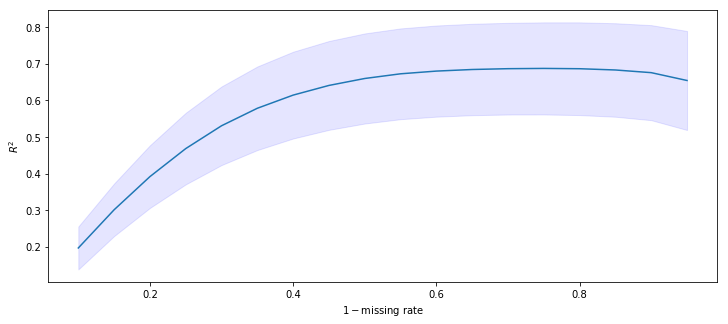

In [86]:
means = np.array([np.mean(s) for s in scores])
stds = np.array([np.std(np.mean(s, axis=0)) for s in scores])

plt.figure(figsize=(12, 5))
t = 2
xs_ = xs[t:]
means_ = means[t:]
stds_ = stds[t:]
df = pd.DataFrame(data=np.array([xs_, means_, stds_]).T, columns=['$1 -$missing rate', '$R^2$', 'std'])
ax = sns.lineplot(x='$1 -$missing rate', y='$R^2$', data=df)
ax.fill_between(xs_, (means_-stds_), (means_+stds_), color='b', alpha=.1);
#plt.xlim(0, 1);

# Save data

In [ ]:
# Save data to CSV for methods implemented in R
x_test_nan = x_test_
x_test_nan[mask == 0] = np.nan

x = np.concatenate((x_train, x_test_nan), axis=0)
num_covs = np.concatenate((num_covs_train, num_covs_test), axis=0)
cat_covs = np.concatenate((cat_covs_train, cat_covs_test), axis=0)
x_ = np.concatenate((x, num_covs, cat_covs), axis=-1)
df_csv = pd.DataFrame(data=x_, index=sampl_ids)
df_csv.astype({12558: 'int32', 12559: 'int32', 12560: 'int32'})
df_csv.to_csv('data/to_impute.csv')

# Save test data to CSV
df_test = pd.DataFrame(data=x_test, index=sampl_ids_test, columns=symbols)
tissues_test = cat_covs_test[:, 2]
df_test['tissue'] = tissues_test
df_test.head()
df_test.to_csv('observed_test.csv')

# Save imputed test data to CSV
x_gen_ = (1 - mask) * x_gen + mask * x_test
df_imputed = pd.DataFrame(data=x_gen_, index=sampl_ids_test, columns=symbols)
tissues_test = cat_covs_test[:, 2]
df_imputed['tissue'] = tissues_test
df_imputed.to_csv('imputed_test.csv')

# Save mask to CSV
df_mask = pd.DataFrame(data=mask, index=sampl_ids_test, columns=symbols)
tissues_test = cat_covs_test[:, 2]
df_mask.to_csv('mask.csv')

In [95]:
# Save whole blood data to CSV for methods implemented in R
blood_idx = tissues_dict['Whole_Blood']
blood_idxs = np.argwhere(tissues_test == blood_idx).ravel()
blood_expr_test = x_test[blood_idxs, :]
blood_cat_covs_test = cat_covs_test[blood_idxs, :]
blood_num_covs_test = num_covs_test[blood_idxs, :]
blood_sample_ids_test = sampl_ids_test[blood_idxs]

blood_idxs = np.argwhere(tissues_train == blood_idx).ravel()
blood_expr_train = x_train[blood_idxs, :]
blood_cat_covs_train = cat_covs_train[blood_idxs, :]
blood_num_covs_train = num_covs_train[blood_idxs, :]
blood_sample_ids_train = sampl_ids_train[blood_idxs]

# Save to impute data for blood tissue
m_rate = 0.5
nb_samples, nb_genes = blood_expr_test.shape
mask_blood, _, _ = get_mask_hint_b(nb_samples, nb_genes, m_low=m_rate, m_high=m_rate)
x_test_nan_test = blood_expr_test
x_test_nan_test[mask_blood == 0] = np.nan

x = np.concatenate((blood_expr_train, x_test_nan_test), axis=0)
num_covs = np.concatenate((blood_num_covs_train, blood_num_covs_test), axis=0)
cat_covs = np.concatenate((blood_cat_covs_train, blood_cat_covs_test), axis=0)
blood_sample_ids = np.concatenate((blood_sample_ids_train, blood_sample_ids_test), axis=0)
x_ = np.concatenate((x, num_covs, cat_covs), axis=-1)
df_csv = pd.DataFrame(data=x_, index=blood_sample_ids)
df_csv.astype({12558: 'int32', 12559: 'int32', 12560: 'int32'})
df_csv.to_csv('data/to_impute_blood.csv')

# Save mask to CSV
df_mask = pd.DataFrame(data=mask_blood, index=blood_sample_ids_test, columns=symbols)
df_mask.to_csv('mask_blood.csv')

# Tissue embeddings

In [48]:
gen.layers[6].get_weights()[0].shape

(49, 8)

In [49]:
embeddings = gen.layers[6].get_weights()[0]
emb_2d = tsne_2d(embeddings)

... performing tSNE


In [114]:
tissues_dict_inv

array(['Adipose_Subcutaneous', 'Adipose_Visceral_Omentum',
       'Adrenal_Gland', 'Artery_Aorta', 'Artery_Coronary',
       'Artery_Tibial', 'Brain_Amygdala', 'Brain_Anterior_cingulate',
       'Brain_Caudate', 'Brain_Cerebellar', 'Brain_Cerebellum',
       'Brain_Cortex', 'Brain_Frontal_Cortex', 'Brain_Hippocampus',
       'Brain_Hypothalamus', 'Brain_Nucleus', 'Brain_Putamen',
       'Brain_Spinal_cord', 'Brain_Substantia_nigra',
       'Breast_Mammary_Tissue', 'Cells_Cultured', 'Cells_EBV',
       'Colon_Sigmoid', 'Colon_Transverse', 'Esophagus_Gastro',
       'Esophagus_Mucosa', 'Esophagus_Muscularis', 'Heart_Atrial',
       'Heart_L_Vent', 'Kidney_Cortex', 'Liver', 'Lung', 'Minor_Salivary',
       'Muscle_Skeletal', 'Nerve_Tibial', 'Ovary', 'Pancreas',
       'Pituitary', 'Prostate', 'Skin_Not_Sun_Epsd', 'Skin_Sun_Epsd',
       'Small_Intestine', 'Spleen', 'Stomach', 'Testis', 'Thyroid',
       'Uterus', 'Vagina', 'Whole_Blood'], dtype='<U24')

In [113]:
embeddings

array([[-3.53920817e-01,  6.17349863e-01,  9.55429077e-01,
        -1.00282156e+00,  9.85555410e-01,  5.66859603e-01,
         6.53991580e-01, -2.61193484e-01],
       [ 3.68319154e-01,  1.21002853e+00,  1.62854540e+00,
         4.60693359e-01,  2.14793980e-02,  1.33572614e+00,
        -2.62525022e-01, -2.09612584e+00],
       [-5.73385835e-01, -1.13053191e+00, -4.81187105e-01,
         1.91035867e-01, -1.29317343e+00, -1.82846797e+00,
         9.71098602e-01, -9.33389544e-01],
       [-3.28596294e-01, -1.94099098e-01,  6.70400977e-01,
        -6.61687791e-01, -8.99521291e-01,  2.75334328e-01,
         1.51814342e-01,  2.47352943e-01],
       [ 6.20609939e-01,  9.78178799e-01, -3.71115297e-01,
        -9.70253468e-01, -1.03474832e+00, -1.04408252e+00,
         3.84887457e-01,  2.73083955e-01],
       [ 6.55884743e-02,  2.18049854e-01,  6.97377741e-01,
        -1.47349954e+00,  1.04386806e+00, -3.20633471e-01,
         6.75544679e-01, -2.93210745e-01],
       [ 7.94950962e-01,  6.454728

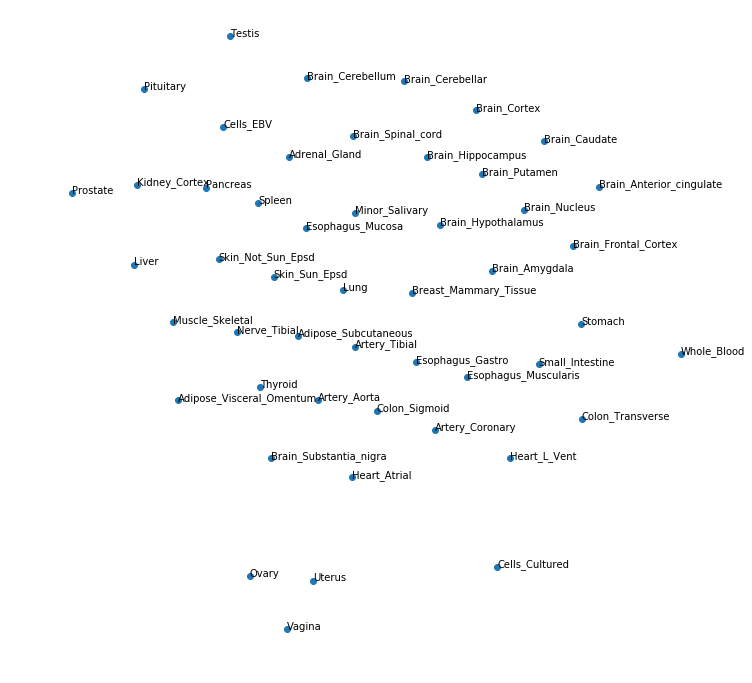

In [67]:
plt.figure(figsize=(12, 12))
ax = plt.gca()
x1, x2 = emb_2d.T
ax.scatter(x1, x2)

for i, txt in enumerate(tissues_dict_inv):
    ax.annotate(txt, (x1[i], x2[i]),
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center')
    
plt.axis('off');

In [111]:
emb_2d_ = tsne_2d(embeddings, perplexity=40)

... performing tSNE


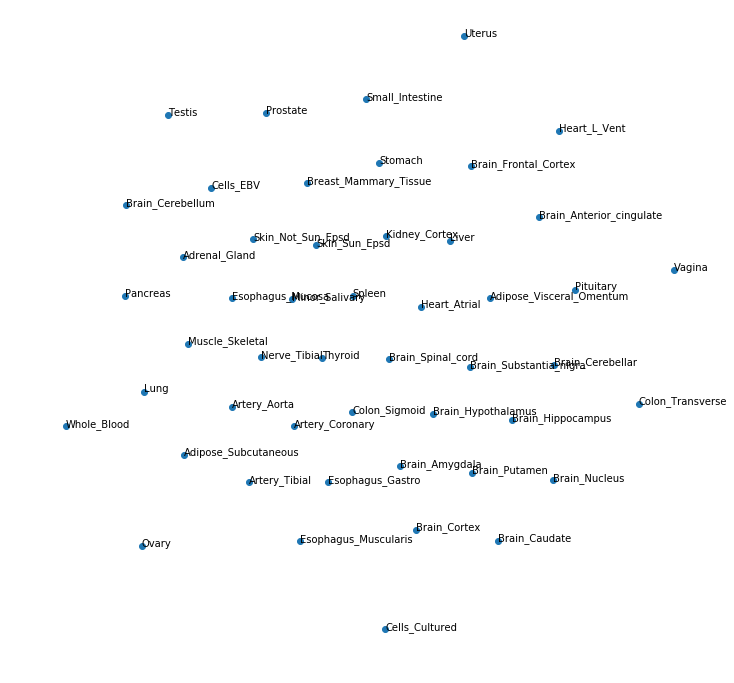

In [112]:
plt.figure(figsize=(12, 12))
ax = plt.gca()
x1, x2 = emb_2d_.T
ax.scatter(x1, x2)

for i, txt in enumerate(tissues_dict_inv):
    ax.annotate(txt, (x1[i], x2[i]))
    
plt.axis('off');

# Evaluate on TCGA

In [7]:
def scores_missing_rate(x_gt, cc_gt, nc_gt, gen, repeats=10):
    scores = []
    xs = np.arange(0.05, 0.9, 0.05)
    
    for m_rate in xs:
        for r in range(repeats):
            mask, _, _ = get_mask_hint_b(x_gt.shape[0], nb_genes, m_low=m_rate, m_high=m_rate)
            x_gt_ = x_gt * mask

            x_gen = predict(x=x_gt_,
                          cc=cc_gt,
                          nc=nc_gt,
                          mask=mask,
                          gen=gen)

            r_sq = r2_scores_(x_gt, x_gen, mask)
            scores.append(r_sq)

        print('Missing rate: {:.2f}. R^2: {:.2f}'.format(m_rate, np.nanmean(r_sq)))
    scores = np.reshape(scores, (-1, repeats, r_sq.shape[0]))
    
    return xs, scores

def r2_scores_(x_gt, x_pred, mask):
    mask_r = np.copy(mask)
    mask_r[mask_r == 1] = np.nan

    gene_means = np.mean(x_gt, axis=0)  # Shape=(nb_genes,)
    mask_r[:, gene_means == 0] = np.nan  # Discard genes with 0 variance
    ss_res = np.nansum((1-mask_r)*(x_gt - x_pred) ** 2, axis=0)
    ss_tot = np.nansum((1-mask_r)*(x_gt - gene_means) ** 2, axis=0)
    r_sq = 1 - ss_res/(ss_tot)
    return r_sq

def get_TCGA(TCGA_TISSUE = 'LUAD'):
    # TCGA data
    if TCGA_TISSUE == 'LAML':
        path = '/local/scratch/rv340/tcga/AML/TCGA-LAML.htseq_fpkm.tsv'  # /LungAdenocarcinoma/TCGA-LUAD.htseq_fpkm.tsv'  # 'AML/TCGA-LAML.htseq_fpkm.tsv'
        clinical = '/local/scratch/rv340/tcga/AML/LAML_clinicalMatrix'
        t = 'Whole_Blood'
    elif TCGA_TISSUE == 'BRCA':
        path = '/local/scratch/rv340/tcga/BreastCancer/TCGA-BRCA.htseq_fpkm.tsv'  # /LungAdenocarcinoma/TCGA-LUAD.htseq_fpkm.tsv'  # 'AML/TCGA-LAML.htseq_fpkm.tsv'
        clinical = '/local/scratch/rv340/tcga/BreastCancer/BRCA_clinicalMatrix'
        t = 'Breast_Mammary_Tissue'
    else:
        path = '/local/scratch/rv340/tcga/LungAdenocarcinoma/TCGA-LUAD.htseq_fpkm.tsv'
        clinical = '/local/scratch/rv340/tcga/LungAdenocarcinoma/LUAD_clinicalMatrix'
        t = 'Lung'
    t_idx = np.argwhere(tissues_dict_inv == t).ravel()[0]
    df = pd.read_csv(path, delimiter='\t')
    df = df.set_index('Ensembl_ID')
    
    # Transform gene symbols
    gene_symbols, ENSEMBL_found = ENSEMBL_to_gene_symbols(df.index)
    df = df.loc[ENSEMBL_found]
    df = df.rename(index=dict(zip(df.index, gene_symbols)))
    df = df.loc[symbols]
    df = df.groupby('Ensembl_ID', group_keys=False).apply(lambda x: x[x.sum(axis=1) == np.max(x.sum(axis=1))])  # Remove duplicates, keep max

    # Standardize data
    x_TCGA = df.values.T
    x_TCGA = (x_TCGA - np.mean(x_TCGA, axis=0))/(np.std(x_TCGA, axis=0) + 1e-7)

    # Process covariates
    clinical_df = pd.read_csv(clinical, delimiter='\t')
    idxs = [np.argwhere(s[:-1] == clinical_df['sampleID']).ravel()[0] for s in df.columns]
    gender = np.array([0 if g == 'MALE' else 1 for g in clinical_df.iloc[idxs]['gender']])
    age = clinical_df.iloc[idxs]['age_at_initial_pathologic_diagnosis'].values
    mean_age = 52.7763  # Mean age GTEx
    std_age = 12.9351  # Std age GTEx
    age = (age - mean_age)/std_age
    cc_TCGA = np.zeros((x_TCGA.shape[0], 3)) + stats.mode(cat_covs).mode
    cc_TCGA[:, 0] = gender
    cc_TCGA[:, 2] = t_idx
    nc_TCGA = age
    
    return x_TCGA, cc_TCGA, nc_TCGA, t, t_idx

def plot_r2_missingrate(xs, scores, label=None):
    means = np.nanmean(scores, axis=(1, 2)) #  np.array([np.nanmean(s) for s in scores_GTEx])
    stds = np.nanmean(np.nanstd(scores, axis=1), axis=-1)
    
    xs_ = xs
    means_ = means
    stds_ = stds
    df = pd.DataFrame(data=np.array([xs_, means_, stds_]).T, columns=['$1 -$missing rate', '$R^2$', 'std'])
    ax = sns.lineplot(x='$1 -$missing rate', y='$R^2$', data=df, label=label)
    ax.fill_between(xs_, (means_-stds_), (means_+stds_), alpha=.1);


def plot_r2_missingrate_(xs, scores_GTEx, scores_TCGA, gtex_tissue, tcga_tissue):
    means_GTEx = np.nanmean(scores_GTEx, axis=(1, 2)) #  np.array([np.nanmean(s) for s in scores_GTEx])
    stds_GTEx = np.nanmean(np.nanstd(scores_GTEx, axis=1), axis=-1)
    means_TCGA = np.nanmean(scores_TCGA, axis=(1, 2))
    stds_TCGA = np.nanmean(np.nanstd(scores_TCGA, axis=1), axis=-1)
    
    xs_ = xs
    means_ = means_GTEx
    stds_ = stds_GTEx
    df = pd.DataFrame(data=np.array([xs_, means_, stds_]).T, columns=['$1 -$missing rate', '$R^2$', 'std'])
    ax = sns.lineplot(x='$1 -$missing rate', y='$R^2$', data=df, label='GTEx {}'.format(gtex_tissue))
    ax.fill_between(xs_, (means_-stds_), (means_+stds_), alpha=.1);

    means_ = means_TCGA
    stds_ = stds_TCGA
    df = pd.DataFrame(data=np.array([xs_, means_, stds_]).T, columns=['$1 -$missing rate', '$R^2$', 'std'])
    ax = sns.lineplot(x='$1 -$missing rate', y='$R^2$', data=df, label='TCGA {}'.format(tcga_tissue))
    ax.fill_between(xs_, (means_-stds_), (means_+stds_), alpha=.1);

In [244]:
x_TCGA, cc_TCGA, nc_TCGA, t, t_idx = get_TCGA('LUAD')

/auto/homes/rv340/adversarial-gtex/gtexenv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [111]:
x_TCGA.shape

(585, 12557)

In [567]:
x_TCGA, cc_TCGA, nc_TCGA, t, t_idx = get_TCGA(TCGA_TISSUE)

mask, _, _ = get_mask_hint_b(x_TCGA.shape[0], nb_genes, m_low=0.5, m_high=0.5)
x_TCGA_ = x_TCGA * mask

x_gen_TCGA = predict(x=x_TCGA_,
                  cc=cc_TCGA,
                  nc=nc_TCGA,
                  mask=mask,
                  gen=gen)

r_sq_TCGA = r2_scores_(x_TCGA, x_gen_TCGA, mask)
np.nanmean(r_sq_TCGA)

/auto/homes/rv340/adversarial-gtex/gtexenv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [246]:
idxs_GTEx = np.argwhere(tissues_test == t_idx).ravel()
x_GTEx = x_test[idxs_GTEx]
cc_GTEx = cat_covs_test[idxs_GTEx]
nc_GTEx = num_covs_test[idxs_GTEx]

In [245]:
xs, scores_GTEx = scores_missing_rate(x_GTEx, cc_GTEx, nc_GTEx, gen)
_, scores_TCGA = scores_missing_rate(x_TCGA, cc_TCGA, nc_TCGA, gen)

NameError: name 'x_GTEx' is not defined

In [ ]:
plt.figure(figsize=(18, 4))

sg = []
st = []
for i, tcga_tissue in enumerate(['LAML', 'BRCA', 'LUAD']):
    x_TCGA, cc_TCGA, nc_TCGA, t, t_idx = get_TCGA(tcga_tissue)
    
    idxs_GTEx = np.argwhere(tissues_test == t_idx).ravel()
    x_GTEx = x_test[idxs_GTEx]
    cc_GTEx = cat_covs_test[idxs_GTEx]
    nc_GTEx = num_covs_test[idxs_GTEx]

    print('GTEx {}'.format(t))
    xs, scores_GTEx = scores_missing_rate(x_GTEx, cc_GTEx, nc_GTEx, gen)
    print('Missing rate 0.5, R^2: {} ({})'.format(np.nanmean(scores_GTEx[9]), np.nanmean(np.nanstd(scores_GTEx[9], axis=0))))
    print('TCGA {}'.format(tcga_tissue))
    _, scores_TCGA = scores_missing_rate(x_TCGA, cc_TCGA, nc_TCGA, gen)
    print('Missing rate 0.5, R^2: {} ({})'.format(np.nanmean(scores_TCGA[9]), np.nanmean(np.nanstd(scores_TCGA[9], axis=0))))

    sg.append(scores_GTEx)
    st.append(scores_TCGA)

GTEx Whole_Blood
Missing rate: 0.05. R^2: 0.09
Missing rate: 0.10. R^2: 0.21
Missing rate: 0.15. R^2: 0.31
Missing rate: 0.20. R^2: 0.41
Missing rate: 0.25. R^2: 0.48
Missing rate: 0.30. R^2: 0.55
Missing rate: 0.35. R^2: 0.59
Missing rate: 0.40. R^2: 0.63
Missing rate: 0.45. R^2: 0.66
Missing rate: 0.50. R^2: 0.68
Missing rate: 0.55. R^2: 0.69
Missing rate: 0.60. R^2: 0.70
Missing rate: 0.65. R^2: 0.70
Missing rate: 0.70. R^2: 0.70
Missing rate: 0.75. R^2: 0.71
Missing rate: 0.80. R^2: 0.70
Missing rate: 0.85. R^2: 0.70
Missing rate 0.5, R^2: 0.6784042119979858 (0.03129684180021286)
TCGA LAML


/auto/homes/rv340/adversarial-gtex/gtexenv/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


Missing rate: 0.05. R^2: 0.04
Missing rate: 0.10. R^2: 0.11
Missing rate: 0.15. R^2: 0.18
Missing rate: 0.20. R^2: 0.23
Missing rate: 0.25. R^2: 0.28
Missing rate: 0.30. R^2: 0.31
Missing rate: 0.35. R^2: 0.34
Missing rate: 0.40. R^2: 0.36
Missing rate: 0.45. R^2: 0.38
Missing rate: 0.50. R^2: 0.39
Missing rate: 0.55. R^2: 0.39
Missing rate: 0.60. R^2: 0.39
Missing rate: 0.65. R^2: 0.40
Missing rate: 0.70. R^2: 0.39
Missing rate: 0.75. R^2: 0.39
Missing rate: 0.80. R^2: 0.38
Missing rate: 0.85. R^2: 0.37


/auto/homes/rv340/adversarial-gtex/gtexenv/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Missing rate 0.5, R^2: 0.38622489015476463 (0.05710590996196367)
GTEx Breast_Mammary_Tissue
Missing rate: 0.05. R^2: 0.10
Missing rate: 0.10. R^2: 0.23
Missing rate: 0.15. R^2: 0.34
Missing rate: 0.20. R^2: 0.44
Missing rate: 0.25. R^2: 0.52
Missing rate: 0.30. R^2: 0.59
Missing rate: 0.35. R^2: 0.64
Missing rate: 0.40. R^2: 0.67
Missing rate: 0.45. R^2: 0.70
Missing rate: 0.50. R^2: 0.72
Missing rate: 0.55. R^2: 0.74
Missing rate: 0.60. R^2: 0.75
Missing rate: 0.65. R^2: 0.75
Missing rate: 0.70. R^2: 0.75
Missing rate: 0.75. R^2: 0.75
Missing rate: 0.80. R^2: 0.75
Missing rate: 0.85. R^2: 0.74
Missing rate 0.5, R^2: 0.724229097366333 (0.036552999168634415)
TCGA BRCA
Missing rate: 0.05. R^2: 0.05
Missing rate: 0.10. R^2: 0.12
Missing rate: 0.15. R^2: 0.19
Missing rate: 0.20. R^2: 0.25
Missing rate: 0.25. R^2: 0.29
Missing rate: 0.30. R^2: 0.33
Missing rate: 0.35. R^2: 0.36
Missing rate: 0.40. R^2: 0.38
Missing rate: 0.45. R^2: 0.40
Missing rate: 0.50. R^2: 0.41
Missing rate: 0.55. R^2:

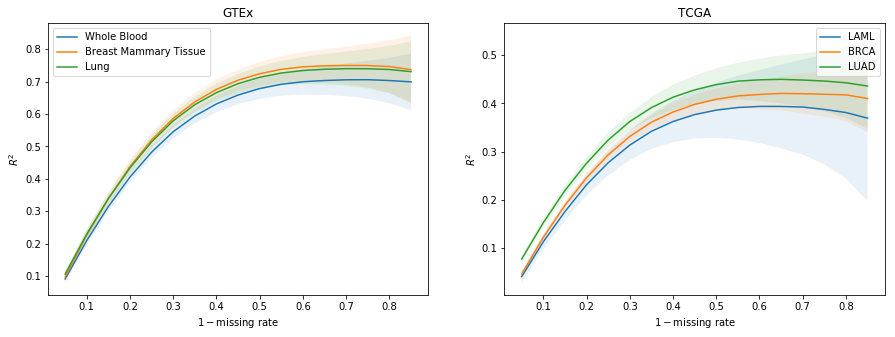

In [254]:
plt.figure(figsize=(15, 5))
plt.tight_layout()
plt.subplot(1, 2, 1)
plot_r2_missingrate(xs, sg[0], 'Whole Blood')
plot_r2_missingrate(xs, sg[1], 'Breast Mammary Tissue')
plot_r2_missingrate(xs, sg[2], 'Lung')
plt.title('GTEx')

plt.subplot(1, 2, 2)
plot_r2_missingrate(xs, st[0], 'LAML')
plot_r2_missingrate(xs, st[1], 'BRCA')
plot_r2_missingrate(xs, st[2], 'LUAD')

plt.title('TCGA')
plt.savefig('r2_missing_rate.pdf', bbox_inches = 'tight', pad_inches = 0);

In [614]:
np.nanmean(st[0][9])  #.shape

0.3859287245151681

In [610]:
np.nanmean(np.nanstd(sg[0][9], axis=0))

0.03147612

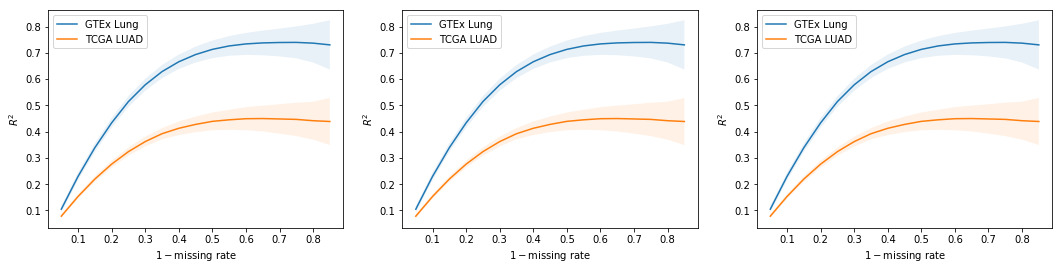

In [565]:
means_GTEx = np.nanmean(scores_GTEx, axis=(1, 2)) #  np.array([np.nanmean(s) for s in scores_GTEx])
stds_GTEx = np.nanmean(np.nanstd(scores_GTEx, axis=1), axis=-1)
means_TCGA = np.nanmean(scores_TCGA, axis=(1, 2))
stds_TCGA = np.nanmean(np.nanstd(scores_TCGA, axis=1), axis=-1)

plt.figure(figsize=(18, 4))
ax=plt.subplot(1, 3, 1)
xs_ = xs
means_ = means_GTEx
stds_ = stds_GTEx
df = pd.DataFrame(data=np.array([xs_, means_, stds_]).T, columns=['$1 -$missing rate', '$R^2$', 'std'])
ax = sns.lineplot(x='$1 -$missing rate', y='$R^2$', data=df, label='GTEx {}'.format(t))
ax.fill_between(xs_, (means_-stds_), (means_+stds_), alpha=.1);

means_ = means_TCGA
stds_ = stds_TCGA
df = pd.DataFrame(data=np.array([xs_, means_, stds_]).T, columns=['$1 -$missing rate', '$R^2$', 'std'])
ax = sns.lineplot(x='$1 -$missing rate', y='$R^2$', data=df, label='TCGA {}'.format(TCGA_TISSUE))
ax.fill_between(xs_, (means_-stds_), (means_+stds_), alpha=.1);

plt.subplot(1, 3, 2)
xs_ = xs
means_ = means_GTEx
stds_ = stds_GTEx
df = pd.DataFrame(data=np.array([xs_, means_, stds_]).T, columns=['$1 -$missing rate', '$R^2$', 'std'])
ax = sns.lineplot(x='$1 -$missing rate', y='$R^2$', data=df, label='GTEx {}'.format(t))
ax.fill_between(xs_, (means_-stds_), (means_+stds_), alpha=.1);

means_ = means_TCGA
stds_ = stds_TCGA
df = pd.DataFrame(data=np.array([xs_, means_, stds_]).T, columns=['$1 -$missing rate', '$R^2$', 'std'])
ax = sns.lineplot(x='$1 -$missing rate', y='$R^2$', data=df, label='TCGA {}'.format(TCGA_TISSUE))
ax.fill_between(xs_, (means_-stds_), (means_+stds_), alpha=.1);

plt.subplot(1, 3, 3)
xs_ = xs
means_ = means_GTEx
stds_ = stds_GTEx
df = pd.DataFrame(data=np.array([xs_, means_, stds_]).T, columns=['$1 -$missing rate', '$R^2$', 'std'])
ax = sns.lineplot(x='$1 -$missing rate', y='$R^2$', data=df, label='GTEx {}'.format(t))
ax.fill_between(xs_, (means_-stds_), (means_+stds_), alpha=.1);

means_ = means_TCGA
stds_ = stds_TCGA
df = pd.DataFrame(data=np.array([xs_, means_, stds_]).T, columns=['$1 -$missing rate', '$R^2$', 'std'])
ax = sns.lineplot(x='$1 -$missing rate', y='$R^2$', data=df, label='TCGA {}'.format(TCGA_TISSUE))
ax.fill_between(xs_, (means_-stds_), (means_+stds_), alpha=.1);



# Single-cell data

In [8]:
path = '/local/scratch/rv340/scRNA/GSM3244108_TS543.UMItab.txt'

In [9]:
df_sc = pd.read_csv(path, delimiter='\t')
df_sc

,ENS_ID,SYMBOL,CTCCTTCAGTA,GCGCTGTTTTTA,TGGCCGTTCGCG,CCCCCTTCTATG,GCGGTTCGCCT,AGAGCTTGGCCG,CGCCCATTATT,ACGCGGTGGACT,...,TGCTTCTACGA,AAACTTTTTAA,TCCAGCCAGCCT,ATTTATACGGTA,AACGAGCAGCGC,TTAGCTAAACAT,GCATCTAACTA,GTATAAACATC,GGGATAACAAA,AGAATTCTTGT
0,ENSG00000234380.1,LINC01426,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENSG00000228481.1,U51244.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000261103.1,RP11-298D21.3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ENSG00000180875.4,GREM2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000213293.4,CTD-2666L21.3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,ENSG00000214215.3,C12orf74,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,ENSG00000225690.1,TREML5P,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,ENSG00000146521.9,LINC01558,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,ENSG00000278883.1,AL591806.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,ENSG00000204634.12,TBC1D8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_sc.shape

(60725, 9926)

In [11]:
df_sc.head()

,ENS_ID,SYMBOL,CTCCTTCAGTA,GCGCTGTTTTTA,TGGCCGTTCGCG,CCCCCTTCTATG,GCGGTTCGCCT,AGAGCTTGGCCG,CGCCCATTATT,ACGCGGTGGACT,...,TGCTTCTACGA,AAACTTTTTAA,TCCAGCCAGCCT,ATTTATACGGTA,AACGAGCAGCGC,TTAGCTAAACAT,GCATCTAACTA,GTATAAACATC,GGGATAACAAA,AGAATTCTTGT
0,ENSG00000234380.1,LINC01426,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENSG00000228481.1,U51244.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000261103.1,RP11-298D21.3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ENSG00000180875.4,GREM2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000213293.4,CTD-2666L21.3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
del df_sc['ENS_ID']

In [13]:
df_sc = df_sc.set_index('SYMBOL')

In [14]:
df_sc_ = df_sc.loc[symbols]
df_sc_ = df_sc_.fillna(0.)
df_sc_

/auto/homes/rv340/adversarial-gtex/gtexenv/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,CTCCTTCAGTA,GCGCTGTTTTTA,TGGCCGTTCGCG,CCCCCTTCTATG,GCGGTTCGCCT,AGAGCTTGGCCG,CGCCCATTATT,ACGCGGTGGACT,ACCGTTAGGAC,TTCGGATTTTT,...,TGCTTCTACGA,AAACTTTTTAA,TCCAGCCAGCCT,ATTTATACGGTA,AACGAGCAGCGC,TTAGCTAAACAT,GCATCTAACTA,GTATAAACATC,GGGATAACAAA,AGAATTCTTGT
SYMBOL,,,,,,,,,,,,,,,,,,,,,
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2LD1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4GALT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACS,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAED1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAB,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
df_sc_.index[np.argwhere(df_sc_.index.duplicated()).ravel()]
df_sc_ = df_sc_.groupby('SYMBOL', group_keys=False).apply(lambda x: x[x.sum(axis=1) == np.max(x.sum(axis=1))])
df_sc_ = df_sc_.loc[~df_sc_.index.duplicated(keep='first')]  # If still some duplicates remain (e.g. all are 0), drop all and keep first

In [16]:
df_sc_.index[np.argwhere(df_sc_.index.duplicated()).ravel()]

Index([], dtype='object', name='SYMBOL')

In [17]:
assert (df_sc_.index.values == symbols).all()

In [18]:
x_sc = df_sc_.values.T
x_sc = (x_sc - np.mean(x_sc, axis=0))/(np.std(x_sc, axis=0) + 1e-7)

In [19]:
x_sc.shape

(9924, 12557)

In [20]:
np.max(x_sc)

99.61375981034419

In [21]:
mean_age = 52.7763  # Mean age GTEx
cc_sc = np.zeros((x_sc.shape[0], 3)) + stats.mode(cat_covs).mode
nc_sc = np.zeros((x_sc.shape[0])) #  + mean_age

In [22]:
mask, _, _ = get_mask_hint_b(x_sc.shape[0], nb_genes, m_low=0.5, m_high=0.5)
x_gen_sc = predict(x=x_sc,
                  cc=cc_sc,
                  nc=nc_sc,
                  mask=mask,
                  gen=gen)

In [23]:
x_gen_sc

array([[-0.85180175,  0.71882397, -0.20687455, ...,  1.2294916 ,
         0.73645604,  2.4926703 ],
       [ 0.7532029 ,  0.35462642,  0.6031809 , ...,  0.782941  ,
         0.7312827 ,  1.5789399 ],
       [ 1.4190267 ,  0.10724261,  0.4057102 , ...,  1.0914553 ,
         0.47084212,  0.6923708 ],
       ...,
       [-0.10829172,  0.07901312,  0.04316901, ..., -0.16127524,
         0.16094947, -0.08588494],
       [-0.35672975,  0.0064656 ,  0.00734519, ..., -0.09974274,
        -0.07687759, -0.12479617],
       [-0.12702057,  0.12860298,  0.06957109, ..., -0.08671331,
        -0.00430989, -0.15785384]], dtype=float32)

In [24]:
r_sq_sc = r2_scores_(x_sc, x_gen_sc, mask)
np.nanmean(r_sq_sc)

/auto/homes/rv340/adversarial-gtex/gtexenv/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


-6.043398748261002

# R squared distributions

In [ ]:
tissues_test

In [58]:
sampl_ids

array(['GTEX-NL4W', 'GTEX-13O3O', 'GTEX-12ZZW', ..., 'GTEX-P44H',
       'GTEX-13U4I', 'GTEX-XMD1'], dtype=object)

In [70]:
genes_r_sq = np.mean(r_sq, axis=0)

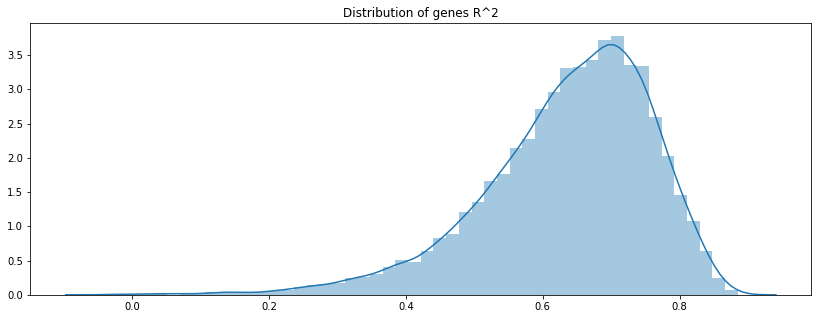

In [71]:
plt.figure(figsize=(14, 5))
plt.title('Distribution of genes R^2')
sns.distplot(genes_r_sq);

In [76]:
r_sq_genes = genes_r_sq

In [77]:
idxs = np.argwhere(r_sq_genes > 0.8).flatten()
symbols[idxs]

array(['ABCE1', 'ABCF2', 'ACTR1A', 'ACTR2', 'ACTR3', 'ADRM1', 'AFF4',
       'AFG3L2', 'ALS2CR8', 'ANAPC11', 'ANXA7', 'APEH', 'API5', 'ARCN1',
       'ARF1', 'ARF4', 'ARF5', 'ARFGAP1', 'ARFGEF2', 'ARHGDIA', 'ARL1',
       'ARL6IP4', 'ARPC1B', 'ARPC3', 'ASNA1', 'ATG3', 'ATG9A', 'ATP5A1',
       'ATP5B', 'ATP5C1', 'ATP5E', 'ATP5F1', 'ATP5G1', 'ATP5G3', 'ATP5H',
       'ATP5I', 'ATP5J', 'ATP5J2', 'ATP5L', 'ATP6AP1', 'ATP6V0C',
       'ATP6V0D1', 'ATP6V0E1', 'ATP6V1D', 'ATP6V1E1', 'ATXN2L', 'AUP1',
       'AURKAIP1', 'BAD', 'BANF1', 'BCL7B', 'BECN1', 'BOD1L', 'BTF3',
       'C11orf58', 'C14orf166', 'C15orf24', 'C19orf10', 'C19orf43',
       'C19orf53', 'C19orf6', 'C1QBP', 'C1QC', 'C1orf122', 'C1orf43',
       'C20orf24', 'C7orf59', 'CACYBP', 'CALU', 'CANX', 'CAPRIN1',
       'CCDC130', 'CCDC47', 'CCNL1', 'CCNL2', 'CCT2', 'CCT3', 'CCT4',
       'CCT5', 'CCT6A', 'CCT7', 'CD63', 'CDC123', 'CDC42', 'CEBPZ',
       'CENPB', 'CENPT', 'CFL1', 'CHCHD2', 'CHERP', 'CHMP2A', 'CHUK',
       'CIAPIN1',

In [30]:
idxs = np.argwhere(r_sq_genes < 0.2).flatten()
symbols[idxs]

array(['ARL17B', 'C21orf33', 'FAM22A', 'GSTM1', 'GTF2H2', 'LDHC',
       'POLR2J2', 'PWP2', 'RP11-1212A22.4', 'RP11-166B2.1',
       'RP11-632K20.1'], dtype=object)